# Generator Network

Our first task in our foray into GANs will be to create a *generator*. Recall a generator $\mathcal{G}: \mathbb{R}^{d} \rightarrow \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$ can be visualized by the computational graph

<img src="images/Fancy G.svg" alt="Drawing" style="width: 300px;"/>

and maps from random points $\mathbf{z} \in \mathbb{R}^{d}$ to synthetic images $\widetilde{\mathbf{X}} \in \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$. For this lab, we will model $\mathcal{G}$ as a computational graph. Since we are considering MNIST digits, we will take C = 1 and W = H = 28 since. We will also be using $d = 100$.

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39200)             3959200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 39200)             156800    
_________________________________________________________________
activation_1 (Activation)    (None, 39200)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 200)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 100)       180100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 100)       400       
__________

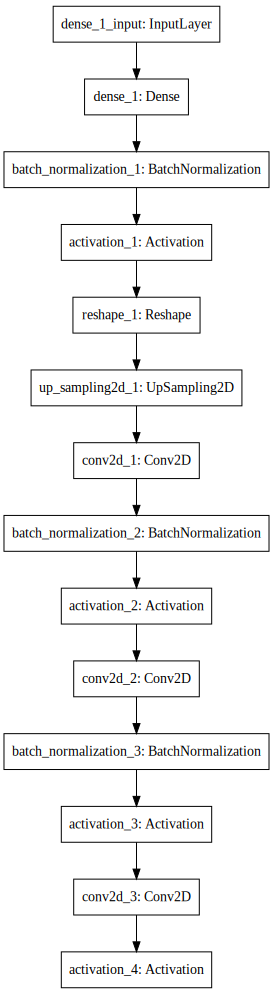

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Reshape, Conv2D, UpSampling2D, BatchNormalization, Activation
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

nb_filter = 200

G = Sequential(name='G')
G.add(Dense(units=nb_filter*14*14, input_shape=[100]))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape([14, 14, nb_filter]))
G.add(UpSampling2D(size=[2, 2]))
G.add(Conv2D(filters=nb_filter//2, kernel_size=3, padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2D(filters=nb_filter//4, kernel_size=3, padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2D(filters=1, kernel_size=1, padding='same'))
G.add(Activation('sigmoid'))

G.summary()
SVG(model_to_dot(G).create(prog='dot', format='svg'))

# Discriminator Network

Our next order of business will be defining a *discriminator* model. Recall a discriminator $\mathcal{D}: \mathbb{R}^{\text{H} \times \text{W} \times \text{C}} \rightarrow \mathbb{R}$ maps an image $\mathbf{X} \in \mathbb{R}^{\text{H} \times \text{W} \times \text{C}}$ to a probability $p \in \mathbb{R}$ that $\mathbf{X}$ came from the data distribution and **not** the generator. We can visualize $\mathcal{D}$ as the computational graph

<img src="images/Fancy D.svg" alt="Discriminator" style="width: 300px;"/>

and as with $\mathcal{G}$, we will model $\mathcal{D}$ as a neural network.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 256)       6656      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 512)         3277312   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 512)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

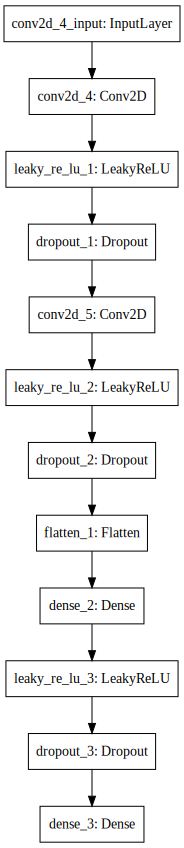

In [2]:
from keras.layers import Input, merge, Dropout, Flatten, LeakyReLU
from keras.models import Model

D = Sequential(name='D')
D.add(Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu', input_shape=[28, 28, 1]))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.25))
D.add(Conv2D(filters=512, kernel_size=5, strides=2, padding='same', activation='relu'))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.25))
D.add(Flatten())
D.add(Dense(units=256, activation='relu'))
D.add(LeakyReLU(0.2))
D.add(Dropout(0.25))
D.add(Dense(units=2, activation='softmax'))
D.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

D.summary()
SVG(model_to_dot(D).create(prog='dot', format='svg'))

# Sample From $\mathcal{G}$

Even though $\mathcal{G}$ is not very good at generating realistic images, we can sample from it to get an idea of the kinds of images it is generating right now. Let's do that now.

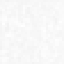

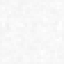

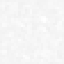

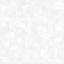

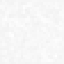

In [3]:
from IPython.display import display
import numpy as np
from keras.preprocessing.image import array_to_img

nb_sample = 5

z = np.random.uniform(size=[nb_sample, 100])
X_fake = G.predict(z)
imgs = [array_to_img(x) for x in X_fake]
imgs = [img.resize(size=[64, 64]) for img in imgs]

for img in imgs:
    display(img)

# Load MNIST Data

For this lab, we will be using the MNIST dataset to train our GAN to produce realistic images of handwritten digits. So the first thing we need to do is load the data!

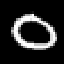

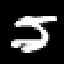

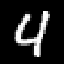

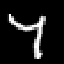

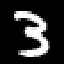

In [4]:
from IPython.display import display
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import array_to_img
from keras.utils import np_utils

[X_mnist, y_mnist], _ = mnist.load_data()
X_mnist = X_mnist.astype('float32') / 255
X_mnist = np.expand_dims(X_mnist, axis=-1)

nb_mnist = len(X_mnist)
for idx in np.random.choice(nb_mnist, size=5, replace=False):
    x = X_mnist[idx]
    img = array_to_img(x).resize(size=[64, 64])
    display(img)

# Pretrain $\mathcal{D}$

One trick for making training GANs easier is to *pretrain* the discriminator $\mathcal{D}$. The intuition behind this is that $\mathcal{G}$ will be able to learn to generate realistic images more quickly if $\mathcal{D}$ already knows the difference between real and fake images.

In [1]:
from keras.utils.np_utils import to_categorical

nb_sample = 1000

z = np.random.uniform(size=[nb_sample, 100])
X_fake = G.predict(z)

y_real, y_fake = np.ones(nb_sample), np.zeros(nb_sample)
X, y = np.concatenate([X_mnist[:nb_sample], X_fake]), np.concatenate([y_real, y_fake])
y[nb_sample:] = 0
Y = to_categorical(y)
Y[np.arange(nb_sample, dtype=np.int), np.ones(nb_sample, dtype=np.int)] = 0.9 # label-smoothing

D.fit(X, Y, epochs=1)

Using TensorFlow backend.


NameError: name 'np' is not defined

# Generative Adversarial Network

Now that we have a generator and a discriminator, let's string them together to make a *generative adversarial network*. Recall that a generative adversarial network $\mathcal{A} = D \circ G$ can be visualized by the computational graph

<img src="images/Fancy GAN.svg" alt="GAN" style="width: 300px;"/>

and consists of a generator $\mathcal{G}$ whose goal is to produce synthetic images $\widetilde{\mathbf{X}} \in \mathbb{R}^{\times \text{W} \times \text{H} \times \text{C}}$, which are realistic enough to fool $\mathcal{D}$ into predicting a value of $p \in \mathbb{R}$ close to 1.0.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
G (Sequential)               (None, 28, 28, 1)         4341801   
_________________________________________________________________
D (Sequential)               (None, 2)                 9707266   
Total params: 14,049,067
Trainable params: 13,970,367
Non-trainable params: 78,700
_________________________________________________________________


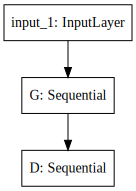

In [5]:
from keras.layers import Input
from keras.models import Model

z = Input(shape=[100])
X_fake = G(z)
p = D(X_fake)

GAN = Model(inputs=z, outputs=p, name='GAN')
GAN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

GAN.summary()
SVG(model_to_dot(GAN).create(prog='dot', format='svg'))

# Train $\mathcal{A}$

We now have all of the pieces in place to optimize $\mathcal{A}$! The core algorithm of training a GAN can be visualized as

<img src="images/GAN Loop.svg" alt="Drawing" style="width: 600px;"/>

where **;** implies concatenation. If you feel ready to implement this algorithm, then skip down to the last code cell and start coding! Otherwise, there is a detailed description at the bottom of this notebook to assist your understanding and the following code cells will allow you to build up to the full solution.

# Detailed Description of Training Algorithm

The training algorithm pictured above can be more understood in more detail as

1. Sample a random $\mathbf{z}$ minibatch and predict $\widetilde{\mathbf{X}} = \mathcal{G}(\mathbf{z})$
2. Sample a $\mathbf{X}$ minibatch
3. Compute $\nabla_{\theta_\mathcal{D}}$ on $([\widetilde{\mathbf{X}} ; \mathbf{X}], [\mathbf{0} ; \mathbf{1}])$ and use it to step $\theta_\mathcal{D}$
4. Freeze $\theta_\mathcal{D}$
5. Compute $\nabla_{\theta_\mathcal{G}}$ on $(\widetilde{\mathbf{X}}, \mathbf{1})$ and step $\theta_\mathcal{G}$
6. Unfreeze $\theta_\mathcal{D}$
7. Go to step 1

In steps 1 and 2, we are simply generating a batch of fake and real images $\widetilde{\mathbf{X}}$ and $\mathbf{X}$. 

In step 3, we are making an update to $\theta_\mathcal{D}$ (e.g. with SGD) so that $\mathcal{D}$ does a little better at telling $\widetilde{\mathbf{X}}$ from $\mathbf{X}$. To accomplish this, we simply pass in the labeled pair $([\widetilde{\mathbf{X}} ; \mathbf{X}], [\mathbf{0} ; \mathbf{1}])$ and compute $\nabla_{\theta_\mathcal{D}}$ via backpropagation. We are now done updating $\theta_\mathcal{D}$ for this round, so we freeze $\theta_\mathcal{D}$ in Step 4.

Now comes the trickiest part of the entire procedure, which takes some explanation.

In Step 5, our goal is to update the $\mathcal{G}$'s weights so they will make $\widetilde{\mathbf{X}}$ a little more realistic. Note that $\nabla_{\theta_\mathcal{G}}$ for the "true" labeling $(\widetilde{\mathbf{X}}, \mathbf{0})$ (as seen in step 3 via backpropagation) tells us how to change $\theta_\mathcal{G}$ so that $\widetilde{\mathbf{X}}$ is a little *less* realistic (i.e. $\mathcal{A}$'s loss would decrease, thus improving $\mathcal{A}$'s accuracy). Since we want to do the opposite (i.e. decreasing $\mathcal{A}$'s accuracy by increasing $\mathcal{A}$'s loss), we pass in an "adversarial" labeling. This will make $\widetilde{\mathbf{X}}$ a little *more* realistic as $\mathcal{A}$'s loss will increase. We compute $\nabla_{\theta_\mathcal{G}}$ via backpropagation with this input pair and step $\theta_\mathcal{G}$ (e.g. with SGD).

In Step 6, we are done updating $\theta_\mathcal{G}$ so we unfreeze $\theta_\mathcal{D}$.

Finally, we go back to Step 1, thus entering the next round.

In [ ]:
from IPython import display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
from lib.keras_utils import freeze
from keras.utils.np_utils import to_categorical

batch_size = 128
nb_epoch = 250
plot_every = 5
y_fake, y_real = np.zeros(batch_size), np.ones(batch_size)

L, A = defaultdict(list), defaultdict(list)
for i in range(nb_epoch):
    batch_idxs, z = np.random.choice(nb_mnist, size=batch_size), np.random.uniform(low=-1, high=1, size=[batch_size, 100])
    X_real, X_fake = X_mnist[batch_idxs], G.predict(z)
    X, y = np.concatenate([X_fake, X_real]), np.concatenate([y_fake, y_real])
    Y = to_categorical(y)
    loss, acc = D.train_on_batch(X, Y)
    L['D_loss'].append(float(loss)); A['D_acc'].append(float(acc))

    z = np.random.uniform(low=-1, high=1, size=[batch_size, 100])
    with freeze(GAN, D):
        loss, acc = GAN.train_on_batch(z, to_categorical(y_real))
    L['G_loss'].append(float(loss)); A['G_acc'].append(float(acc))
    
    if i == 0 or not i % plot_every == 0:
        continue
        
    display.clear_output(wait=True)
    pd.DataFrame(L).plot(title='Batch {}/{}'.format(i, nb_epoch))
    axes = pd.DataFrame(A).plot(title='Batch {}/{}'.format(i, nb_epoch))
    axes.set_ylim([0, 1])
    plt.show()

    z = np.random.uniform(low=-1, high=1, size=[8, 100])
    X_fake = G.predict(z)
    for x in X_fake:
        img = array_to_img(x).resize(size=[64, 64])
        display.display(img)